## `Сегментация`

In [ ]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from skimage import measure
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.morphology import dilation, disk
from skimage.draw import polygon_perimeter

In [ ]:
import tensorflow as tf

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

Tensorflow version 2.16.1
GPU is OFF


In [ ]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

## Подготовка набора данных для обучения

In [ ]:
CLASSES = 8  # количество классов + 1 для обозначения заднего фона
COLORS = ['black', 'red', 'lime', 'blue', 'orange', 'pink', 'cyan', 'magenta']
SAMPLE_SIZE = (256, 256)  # фиксированный размер входного изображения
OUTPUT_SIZE = (1080, 1920)  # Размер изображения при формировании данных после обработки

In [ ]:
def load_images(image:str, mask:str):
    """
    загрузка изображений и масок по пути
    преобразование в необходимый формат
    """
    image = tf.io.read_file(image) # считка данных по пути
    image = tf.io.decode_jpeg(image) # раскодировка бинарника jpeg в массив
    image = tf.image.resize(image, OUTPUT_SIZE) # изменение размера
    image = tf.image.convert_image_dtype(image, tf.float32) # приведение к единому типу
    image = image / 255.0 # нормализация
    
    mask = tf.io.read_file(mask) # считка данных по пути
    mask = tf.io.decode_png(mask) # раскодировка бинарника png в массив
    mask = tf.image.rgb_to_grayscale(mask) # перевод в оттенки серого
    mask = tf.image.resize(mask, OUTPUT_SIZE) # изменение размера
    mask = tf.image.convert_image_dtype(mask, tf.float32) # приведение к единому типу
    
    # разделение массива маски с разными классами на многомерный массив с единым классов в своем пространстве
    masks = []
    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))
    
    # формирование бинарных многоканальных изображений
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks

In [ ]:
def augmentate_images(image, masks):
    """
    прием RGB изображений и многоканальной маски
    проведение преобразований с ними
    """
    # искуственное увеличение набора данных

    # извленение кропа со случаным масштабом
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    # случайное отображение изображения по горизонтали
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    # расайз
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)
    
    return image, masks

пути загрузки данных

In [ ]:
images = sorted(glob.glob('C:\ML\DataBases\img_segmentation\images\*.jpg'))
masks = sorted(glob.glob('C:\ML\DataBases\img_segmentation\masks\*.png'))

формирование данных в формате тензора

In [ ]:
images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

объединение тензоров для параллельной обработки

In [ ]:
dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

загрузка данных в память

In [ ]:
dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)

увеличение объема данных простым копированием

In [ ]:
dataset = dataset.repeat(60)

аугментация

In [ ]:
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)

## Визуализация содержимого набора данных

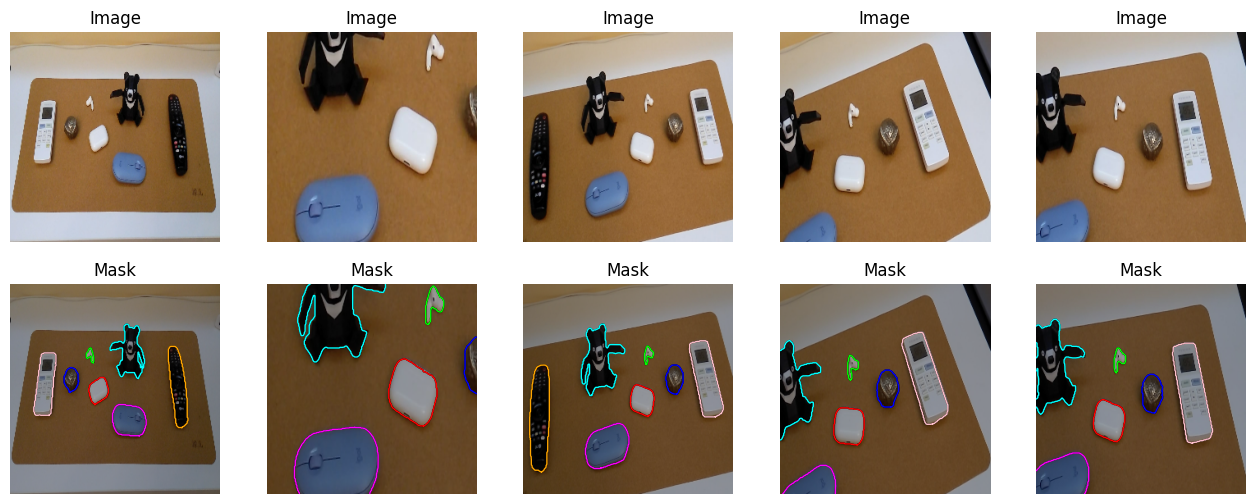

In [ ]:
images_and_masks = list(dataset.take(5))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(16, 6))

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)
        
    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()    
    ax[1, i].imshow(image/1.5)
   
    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()


## Разделение данных на обучающие и тестовые

In [ ]:
train_dataset = dataset.take(2000).cache()
test_dataset = dataset.skip(2000).take(100).cache()

In [ ]:
train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)

## Обозначим основные блоки модели

можно обрабатывать изображения двумя путями:

- большое изображение разбить на мелкие окошки и скормить последовательно нейронке
- изменить размер исходного изображения и скормить нейронке

используем 2 способ

In [ ]:
def input_layer():
    """Входной слой для установления входных данных"""
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    """Encoder"""

    # инициализация весовых коэф
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    # сверточный слой
    result.add(
      tf.keras.layers.Conv2D(filters, size, 
                             strides=2,  # для НЕиспользования Pooling далее
                             padding='same',
                             kernel_initializer=initializer, use_bias=False))

    # нормализация
    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    
    # ф-я активации
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    """Decoder"""
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    # для проведения обратной свертки и увеличить размерность выходны данных
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, 
                                        strides=2, # для НЕиспользования Pooling далее
                                        padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    # нормализация для увеличения производительности
    result.add(tf.keras.layers.BatchNormalization())
    
    # инструмент предотвращения переобучения
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))
    
    # ф-я активации
    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    """Выходной слой"""
    # выходные веса
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

In [ ]:
inp_layer = input_layer()

# массив encoder
downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

# массив декодер
upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)
    
downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

In [ ]:
unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

In [ ]:
def dice_mc_metric(a, b):
    """Dice"""
    # распаовка многоканального изображения маски
    a = tf.unstack(a, axis=3) # ответ нейронки
    b = tf.unstack(b, axis=3) # истинный результат
    
    # нахождение среднего значения коэф Dice
    dice_summ = 0

    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator
        
    avg_dice = dice_summ / CLASSES
    
    return avg_dice

def dice_mc_loss(a, b):
    """Ф-я потерь Dice"""
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    """Комбинация ф-й потерь = генеральная ф-я потерь"""
    # 0.3 = степень влияния Dice в комбинации
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

In [ ]:
unet_like.compile(optimizer='adam', # без настройки гиперпараметров, adam все решит сам
                  loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

In [ ]:
epochs = 6

In [ ]:
history_dice = unet_like.fit(train_dataset, 
                             validation_data=test_dataset, 
                             epochs=epochs, 
                             initial_epoch=0)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 249s 995ms/step - dice_mc_metric: 0.9489 - loss: 0.0254 - val_dice_mc_metric: 0.9608 - val_loss: 0.0199
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 249s 994ms/step - dice_mc_metric: 0.9752 - loss: 0.0124 - val_dice_mc_metric: 0.8797 - val_loss: 0.0788
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 247s 988ms/step - dice_mc_metric: 0.9608 - loss: 0.0196 - val_dice_mc_metric: 0.9759 - val_loss: 0.0121
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 248s 993ms/step - dice_mc_metric: 0.9785 - loss: 0.0111 - val_dice_mc_metric: 0.9755 - val_loss: 0.0123
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 247s 988ms/step - dice_mc_metric: 0.9780 - loss: 0.0113 - val_dice_mc_metric: 0.9819 - val_loss: 0.0091
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 247s 988ms/step - dice_mc_metric: 0.9830 - loss: 0.0087 - val_dice_mc_metric: 0.9831 - val_loss: 0.0086


In [ ]:
unet_like.save('model.h5')

In [ ]:
unet_like = tf.keras.models.load_model('model.h5')

# Проверим работу сети на всех кадрах из видео

In [ ]:
rgb_colors = [
    (0,   0,   0),
    (255, 0,   0),
    (0,   255, 0),
    (0,   0,   255),
    (255, 165, 0),
    (255, 192, 203),
    (0,   255, 255),
    (255, 0,   255)
]

In [ ]:
frames = sorted(glob.glob("C:\ML\DataBases\img_segmentation\original_video\*.jpg"))

In [ ]:
for filename in frames:
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)
    
    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))
        
    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]
    
    frame = (frame / 1.5).astype(np.uint8)
    
    for channel in range(1, CLASSES): 
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))
        
        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)
                
                contour_overlay[rr, cc] = 1        
            
            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except:
            pass

    imsave(f'videos/processed/{os.path.basename(filename)}', frame)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━